In [1]:
import os
import glob
import pandas
import random
import itertools
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch import nn
import torch.nn.init as init
import torchvision.transforms as transforms
from PIL import Image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
class ImageDataset(Dataset):
    def __init__(self,transforms_=None, unaligned=False, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(f"/kaggle/input/monet2photo/{mode}A/*.jpg"))[:250]
        self.files_B = sorted(glob.glob(f"/kaggle/input/monet2photo/{mode}B/*.jpg"))


    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])
        image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])

        # Convert grayscale images to rgb
        if image_A.mode != "RGB":
            image_A = to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = to_rgb(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {"A": item_A, "B": item_B}


    def __len__(self):
        return min(len(self.files_A), len(self.files_B))
    
class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images.data:
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:
                    random_id = random.randint(0, self.pool_size-1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return_images = Variable(torch.cat(return_images, 0))
        return return_images

In [10]:
img_height = 256
img_width = 256
transforms_ = [
    transforms.Resize(256),
#     transforms.RandomCrop((img_height, img_width)),
#     transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

In [11]:
ds_train = ImageDataset(transforms_=transforms_, unaligned=True)
ds_test = ImageDataset(transforms_=transforms_, unaligned=True, mode='test'),

In [12]:
len(ds_train)

250

In [13]:
train_data = DataLoader(
    ds_train,
    batch_size=1, # 1
)

test_data = DataLoader(
    ds_test,
    batch_size=1
)

In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # padding, keep the image size constant after next conv2d
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels)
        )
    
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    
    def __init__(self, in_channels = 3):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 64,
                               kernel_size=7, stride = 1, padding = 3)
        self.bn1 = nn.InstanceNorm2d(64)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 128,
                               kernel_size = 3, stride = 2, padding = 1)
        self.bn2 = nn.InstanceNorm2d(128)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 256,
                               kernel_size = 3, stride = 2, padding = 1)
        self.bn3 = nn.InstanceNorm2d(256)
        self.relu3 = nn.ReLU()
        self.rb = nn.Sequential(*[ResidualBlock(256) for i in range(10)])
        self.convtr1 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128,
                                          kernel_size = 3, stride = 2, padding = 1,
                                          output_padding = 1)
        self.bn4 = nn.InstanceNorm2d(128)
        self.relu4 = nn.ReLU()
        self.convtr2 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64,
                                         kernel_size = 3, stride = 2, padding = 1,
                                         output_padding = 1)
        self.bn5 = nn.InstanceNorm2d(64)
        self.relu5 = nn.ReLU()
        self.convtr3 = nn.Conv2d(in_channels = 64, out_channels = 3,
                                 kernel_size = 7, stride = 1, padding = 3)
        self.tanh = nn.Tanh()
    def forward(self, x):
        x1 = self.relu1(self.bn1(self.conv1(x)))
        x2 = self.relu2(self.bn2(self.conv2(x1)))
        x3 = self.relu3(self.bn3(self.conv3(x2)))
        
        x4 = self.rb(x3)
        
        x5 = self.relu4(self.bn4(self.convtr1(x4)))
        x6 = self.relu5(self.bn5(self.convtr2(x5)))
        x7 = self.convtr3(x6)
        
        out = self.tanh(x7)
        
        return out
    
class Discriminator(nn.Module):
    
    def __init__(self, in_channels = 3):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 64,
                               kernel_size = 4, stride = 2, padding = 1)
        self.bn1 = nn.InstanceNorm2d(64)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 128,
                               kernel_size = 4, stride = 2, padding = 1)
        self.bn2 = nn.InstanceNorm2d(128)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 256,
                               kernel_size = 4, stride = 2, padding = 1)
        self.bn3 = nn.InstanceNorm2d(256)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels = 256, out_channels = 512,
                               kernel_size = 4, stride = 2, padding = 1)
        self.bn4 = nn.InstanceNorm2d(512)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(in_channels = 512, out_channels = 1,
                               kernel_size = 4, stride = 2, padding = 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        x1 = self.relu1(self.bn1(self.conv1(x)))
        x2 = self.relu2(self.bn2(self.conv2(x1)))
        x3 = self.relu3(self.bn3(self.conv3(x2)))
        x4 = self.relu4(self.bn4(self.conv4(x3)))
        out = self.sigmoid(self.conv5(x4))
        
        return out

In [15]:
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            init.normal_(m.weight.data, 0.0, gain)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)
    net.apply(init_func)

In [16]:
class lr_sched():
    def __init__(self, decay_epochs=100, total_epochs=200):
        self.decay_epochs = decay_epochs
        self.total_epochs = total_epochs

    def step(self, epoch_num):
        if epoch_num <= self.decay_epochs:
            return 1.0
        else:
            fract = (epoch_num - self.decay_epochs)  / (self.total_epochs - self.decay_epochs)
            return 1.0 - fract

In [19]:
class CycleGAN(nn.Module):
    def __init__(self, device = 'cpu', epochs = 200, decay_epoch = 0):
        super().__init__()

        self.g_ab = Generator().to(device)
        self.g_ba = Generator().to(device)
        self.d_ab = Discriminator().to(device)
        self.d_ba = Discriminator().to(device)
        self.gen_opt = torch.optim.Adam(itertools.chain(self.g_ab.parameters(), self.g_ba.parameters()),
                                         lr = 0.0005, betas=(0.5, 0.999))
        self.disc_opt = torch.optim.Adam(itertools.chain(self.d_ab.parameters(), self.d_ba.parameters()),
                                         lr = 0.0005, betas=(0.5, 0.999))
        self.lambda_coef = 10
        self.idt_coef = 0.5
        self.device = device
        self.epochs = epochs
        self.mse_loss = nn.MSELoss()
        self.cycle_loss = nn.L1Loss()
        self.decay_epoch = decay_epoch if decay_epoch > 0 else int(self.epochs/2)
        g_step = lr_sched(self.decay_epoch, self.epochs).step
        d_step = lr_sched(self.decay_epoch, self.epochs).step
        self.g_lr = torch.optim.lr_scheduler.LambdaLR(self.gen_opt, g_step)
        self.d_lr = torch.optim.lr_scheduler.LambdaLR(self.disc_opt, d_step)
        self.init_models()
        
    def init_models(self):
        init_weights(self.g_ab)
        init_weights(self.g_ba)
        init_weights(self.d_ab)
        init_weights(self.d_ba)
        self.g_ab = self.g_ab.to(self.device)
        self.g_ba = self.g_ba.to(self.device)
        self.d_ab = self.d_ab.to(self.device)
        self.d_ba = self.d_ba.to(self.device)
        
    def train(self, data_train, data_test):
        num_pool = 50
        fake_A_pool = ImagePool(num_pool)
        fake_B_pool = ImagePool(num_pool)
        for epoch in range(self.epochs):
            avg_g_loss = 0
            avg_d_loss = 0
            for batch in (data_train):
                img_a, img_b = batch['A'].to(self.device), batch['B'].to(self.device)

                # backward Generator
                self.gen_opt.zero_grad()

                fake_a = self.g_ba(img_b)
                pred_fake_a = self.d_ba(fake_a)
                real = Variable(torch.ones(pred_fake_a.size()).to(self.device))
                loss_g_a = self.mse_loss(pred_fake_a, real)


                fake_b = self.g_ab(img_a)
                pred_fake_b = self.d_ab(fake_b)
                loss_g_b = self.mse_loss(pred_fake_b, real)


                cycle_a = self.g_ba(fake_b)
                cycle_b = self.g_ab(fake_a) 

                idt_a = self.g_ba(img_a)
                idt_b = self.g_ab(img_b)

                idt_loss_a = self.cycle_loss(idt_a, img_a) * self.lambda_coef * self.idt_coef
                idt_loss_b = self.cycle_loss(idt_b, img_b) * self.lambda_coef * self.idt_coef


                loss_cycle_a = self.cycle_loss(cycle_a, img_a) * self.lambda_coef
                loss_cycle_b = self.cycle_loss(cycle_b, img_b) * self.lambda_coef

                total_gen_loss = loss_g_a + loss_g_b + loss_cycle_a + loss_cycle_b + idt_loss_a + idt_loss_b
                total_gen_loss.backward()
                self.gen_opt.step()

                #backward D
                self.disc_opt.zero_grad()

                pred_real_b = self.d_ab(img_b)
                pred_real_a = self.d_ba(img_a)

                real = torch.ones(pred_real_a.size()).to(self.device)
                fake = torch.zeros(pred_fake_b.size()).to(self.device)
                
                fake_a = fake_A_pool.query(fake_a)
                fake_b = fake_A_pool.query(fake_b)

                pred_fake_a = self.d_ba(fake_a)
                pred_fake_b = self.d_ab(fake_b)


                loss_d_ab_real = self.mse_loss(pred_real_b, real)
                loss_d_ab_fake = self.mse_loss(pred_fake_b, fake)
                loss_d_ab = (loss_d_ab_real + loss_d_ab_fake)*0.5

                loss_d_ba_real = self.mse_loss(pred_real_a, real)
                loss_d_ba_fake = self.mse_loss(pred_fake_a, fake)
                loss_d_ba = (loss_d_ab_real + loss_d_ab_fake)*0.5

                total_disc_loss = (loss_d_ba + loss_d_ab)

                loss_d_ba.backward(retain_graph = True)
                loss_d_ab.backward(retain_graph = True)
                self.disc_opt.step()

                avg_g_loss += total_gen_loss / len(data_train)
                avg_d_loss += total_disc_loss / len(data_train)
            
            self.g_lr.step()
            self.d_lr.step()
                
            print("Epoch: (%d) | Generator Loss:%f | Discriminator Loss:%f" % 
                                                    (epoch+1, avg_g_loss, avg_d_loss))
            if (epoch+1) % 10 == 0:
                plt.figure()

        #subplot(r,c) provide the no. of rows and columns
                f, axarr = plt.subplots(2,2)

                # use the created array to output your multiple images. In this case I have stacked 4 images vertically
                axarr[0,0].imshow(img_a[0].cpu().permute(1,2,0).numpy())
                axarr[0,1].imshow(img_b[0].cpu().permute(1,2,0).numpy())
                axarr[1,0].imshow(fake_b[0].cpu().permute(1,2,0).numpy())
                axarr[1,1].imshow(fake_a[0].cpu().permute(1,2,0).numpy())

                plt.show()

In [20]:
cgan = CycleGAN(device = device)

Epoch: (1) | Generator Loss:10.705649 | Discriminator Loss:0.456838
Epoch: (2) | Generator Loss:9.371076 | Discriminator Loss:0.414606
Epoch: (3) | Generator Loss:9.054862 | Discriminator Loss:0.415993
Epoch: (4) | Generator Loss:9.040645 | Discriminator Loss:0.385720
Epoch: (5) | Generator Loss:8.435036 | Discriminator Loss:0.425570
Epoch: (6) | Generator Loss:8.693055 | Discriminator Loss:0.372053
Epoch: (7) | Generator Loss:8.438706 | Discriminator Loss:0.380914
Epoch: (8) | Generator Loss:8.088827 | Discriminator Loss:0.361328
Epoch: (9) | Generator Loss:7.872567 | Discriminator Loss:0.359752
Epoch: (10) | Generator Loss:7.633208 | Discriminator Loss:0.328500


<Figure size 640x480 with 0 Axes>

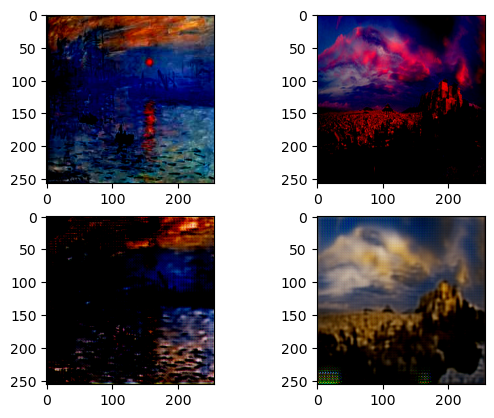

Epoch: (11) | Generator Loss:7.626499 | Discriminator Loss:0.304302
Epoch: (12) | Generator Loss:8.091642 | Discriminator Loss:0.317715
Epoch: (13) | Generator Loss:7.752843 | Discriminator Loss:0.354758
Epoch: (14) | Generator Loss:7.560944 | Discriminator Loss:0.336050
Epoch: (15) | Generator Loss:7.372139 | Discriminator Loss:0.359629
Epoch: (16) | Generator Loss:7.385343 | Discriminator Loss:0.368167
Epoch: (17) | Generator Loss:6.996190 | Discriminator Loss:0.349687
Epoch: (18) | Generator Loss:7.117194 | Discriminator Loss:0.318237
Epoch: (19) | Generator Loss:7.800859 | Discriminator Loss:0.347752
Epoch: (20) | Generator Loss:6.938549 | Discriminator Loss:0.304828


<Figure size 640x480 with 0 Axes>

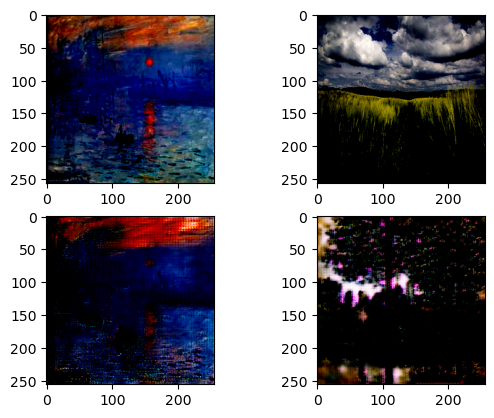

Epoch: (21) | Generator Loss:6.872191 | Discriminator Loss:0.313130
Epoch: (22) | Generator Loss:6.996973 | Discriminator Loss:0.335622
Epoch: (23) | Generator Loss:6.666912 | Discriminator Loss:0.343562
Epoch: (24) | Generator Loss:6.495553 | Discriminator Loss:0.321266
Epoch: (25) | Generator Loss:6.757213 | Discriminator Loss:0.292844
Epoch: (26) | Generator Loss:6.734666 | Discriminator Loss:0.270467
Epoch: (27) | Generator Loss:6.412547 | Discriminator Loss:0.298338
Epoch: (28) | Generator Loss:6.435267 | Discriminator Loss:0.311212
Epoch: (29) | Generator Loss:6.331209 | Discriminator Loss:0.260554
Epoch: (30) | Generator Loss:6.312310 | Discriminator Loss:0.283681


<Figure size 640x480 with 0 Axes>

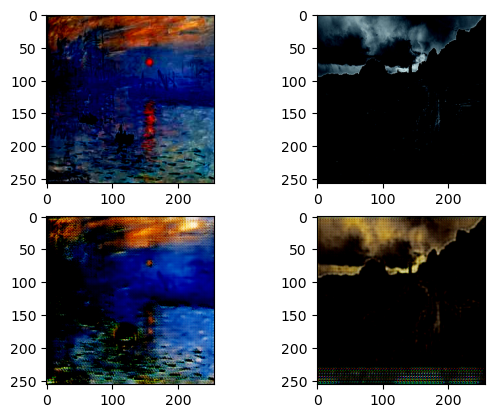

Epoch: (31) | Generator Loss:6.351635 | Discriminator Loss:0.249949
Epoch: (32) | Generator Loss:6.447728 | Discriminator Loss:0.250332
Epoch: (33) | Generator Loss:6.305586 | Discriminator Loss:0.272602
Epoch: (34) | Generator Loss:6.049438 | Discriminator Loss:0.286571
Epoch: (35) | Generator Loss:6.119373 | Discriminator Loss:0.277856
Epoch: (36) | Generator Loss:6.380044 | Discriminator Loss:0.284004
Epoch: (37) | Generator Loss:6.068474 | Discriminator Loss:0.267343
Epoch: (38) | Generator Loss:6.101406 | Discriminator Loss:0.255164
Epoch: (39) | Generator Loss:5.738112 | Discriminator Loss:0.265318
Epoch: (40) | Generator Loss:5.901815 | Discriminator Loss:0.227662


<Figure size 640x480 with 0 Axes>

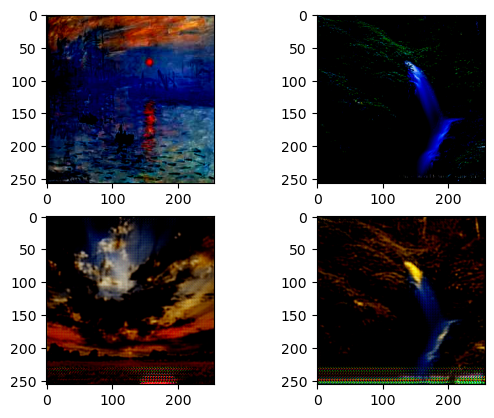

Epoch: (41) | Generator Loss:5.895359 | Discriminator Loss:0.237048
Epoch: (42) | Generator Loss:5.932551 | Discriminator Loss:0.267110
Epoch: (43) | Generator Loss:5.787661 | Discriminator Loss:0.239001
Epoch: (44) | Generator Loss:5.802178 | Discriminator Loss:0.261544
Epoch: (45) | Generator Loss:5.718689 | Discriminator Loss:0.271096
Epoch: (46) | Generator Loss:5.551101 | Discriminator Loss:0.254704
Epoch: (47) | Generator Loss:5.813706 | Discriminator Loss:0.222733
Epoch: (48) | Generator Loss:5.611685 | Discriminator Loss:0.236570
Epoch: (49) | Generator Loss:5.694959 | Discriminator Loss:0.199914
Epoch: (50) | Generator Loss:5.578502 | Discriminator Loss:0.238981


<Figure size 640x480 with 0 Axes>

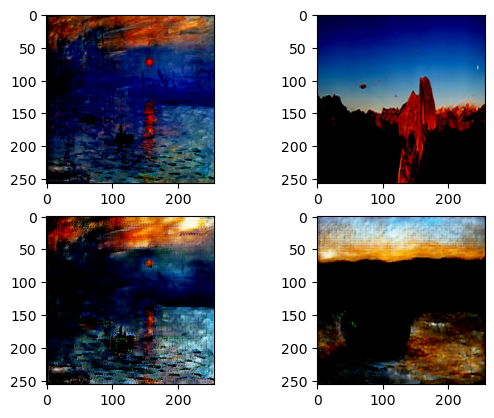

Epoch: (51) | Generator Loss:5.493596 | Discriminator Loss:0.243787
Epoch: (52) | Generator Loss:5.505928 | Discriminator Loss:0.214481
Epoch: (53) | Generator Loss:5.381084 | Discriminator Loss:0.227517
Epoch: (54) | Generator Loss:5.436760 | Discriminator Loss:0.240953
Epoch: (55) | Generator Loss:5.404994 | Discriminator Loss:0.251997
Epoch: (56) | Generator Loss:5.413731 | Discriminator Loss:0.223085
Epoch: (57) | Generator Loss:5.506718 | Discriminator Loss:0.204028
Epoch: (58) | Generator Loss:5.353418 | Discriminator Loss:0.208143
Epoch: (59) | Generator Loss:5.402565 | Discriminator Loss:0.222377
Epoch: (60) | Generator Loss:5.366198 | Discriminator Loss:0.193468


<Figure size 640x480 with 0 Axes>

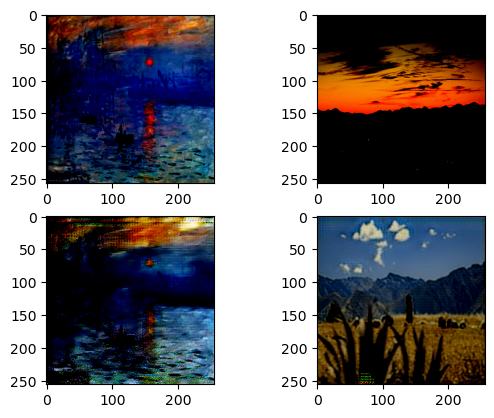

Epoch: (61) | Generator Loss:5.416823 | Discriminator Loss:0.173582
Epoch: (62) | Generator Loss:5.513588 | Discriminator Loss:0.220539
Epoch: (63) | Generator Loss:5.925854 | Discriminator Loss:0.195430
Epoch: (64) | Generator Loss:5.480769 | Discriminator Loss:0.202148
Epoch: (65) | Generator Loss:5.425642 | Discriminator Loss:0.216507
Epoch: (66) | Generator Loss:5.305011 | Discriminator Loss:0.179114
Epoch: (67) | Generator Loss:5.223404 | Discriminator Loss:0.219132
Epoch: (68) | Generator Loss:5.167577 | Discriminator Loss:0.210886
Epoch: (69) | Generator Loss:5.134707 | Discriminator Loss:0.192817
Epoch: (70) | Generator Loss:5.128174 | Discriminator Loss:0.184801


<Figure size 640x480 with 0 Axes>

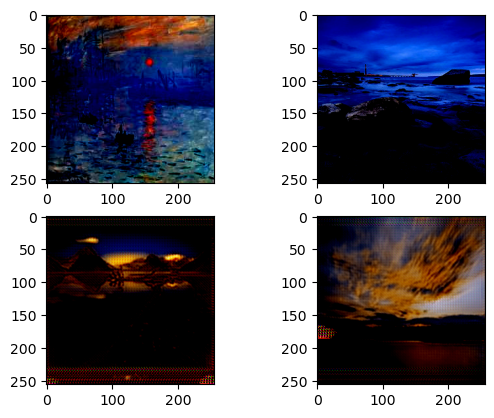

Epoch: (71) | Generator Loss:5.131785 | Discriminator Loss:0.172215


In [ ]:
cgan.train(train_data, test_data)

In [ ]:
def sample_images(real_A, real_B, figside=1.5):
    Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
    assert real_A.size() == real_B.size(), 'The image size for two domains must be the same'
    
    G_AB.eval()
    G_BA.eval()
    
    real_A = real_A.type(Tensor)
    fake_B = G_AB(real_A).detach()
    real_B = real_B.type(Tensor)
    fake_A = G_BA(real_B).detach()
    
    nrows = real_A.size(0)
    real_A = make_grid(real_A, nrow=nrows, normalize=True)
    fake_B = make_grid(fake_B, nrow=nrows, normalize=True)
    real_B = make_grid(real_B, nrow=nrows, normalize=True)
    fake_A = make_grid(fake_A, nrow=nrows, normalize=True)
    
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1).cpu().permute(1, 2, 0)
    
    plt.figure(figsize=(figside*nrows, figside*4))
    plt.imshow(image_grid)
    plt.axis('off')
    plt.show()
    

In [ ]:
torch.save(cgan.state_dict(), 'cgan_weights1.pth')

In [ ]:
torch.save(cgan, 'cgan1.pth')